<h1>Base Matrix Factorization Recommender System</h1>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import math
from models.BaseCFModel import BaseCFModel
from tensorflow.keras.layers import Input, Embedding, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
DATA_PATH = '../data/ml-latest-small'

In [3]:
ratings_matrix = pd.read_csv(f'{DATA_PATH}/ratings.csv')
ratings_matrix.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
dict_movies = {}
count = 0
for _id in sorted(np.unique(ratings_matrix.movieId)):
    if _id not in dict_movies.keys():
        dict_movies[_id] = count
        count += 1        

In [5]:
ratings_matrix = ratings_matrix.replace({'movieId': dict_movies})

In [6]:
N_USERS = len(np.unique(ratings_matrix['userId']))
N_MOVIES = len(np.unique(ratings_matrix['movieId']))

In [7]:
print(f'Number of users in the data set: {N_USERS} \nNumber of movies in the data set: {N_MOVIES}')

Number of users in the data set: 610 
Number of movies in the data set: 9724


In [8]:
ratings_matrix.userId = ratings_matrix.userId - 1

In [9]:
LATENT_FACTORS = [3, 19, 100, 300]

In [10]:
train_data, test_data = train_test_split(ratings_matrix,
                                         test_size = 0.2, 
                                         random_state = 0)

In [11]:
movies_data = pd.read_csv(f'{DATA_PATH}/movies.csv')
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
USER_ID = 5
MOVIES_TO_RECOMMEND = 3

In [13]:
reverse_dict_movies = {}
for item in dict_movies.items():
    reverse_dict_movies[item[1]] = item[0]

In [14]:
movies_wathced_by_user = ratings_matrix[ratings_matrix.userId == USER_ID]
movies_not_watched = movies_data[~movies_data["movieId"].isin(movies_wathced_by_user.movieId.values)]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(dict_movies.keys()))
)
movies_not_watched = [[dict_movies.get(x)] for x in movies_not_watched]

Model: "MatrixFactorizationReccomender"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MoviesInput (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
UsersInput (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
MoviesEmbedding (Embedding)     (None, 1, 3)         29172       MoviesInput[0][0]                
__________________________________________________________________________________________________
UsersEmbedding (Embedding)      (None, 1, 3)         1830        UsersInput[0][0]                 
_____________________________________________________________________

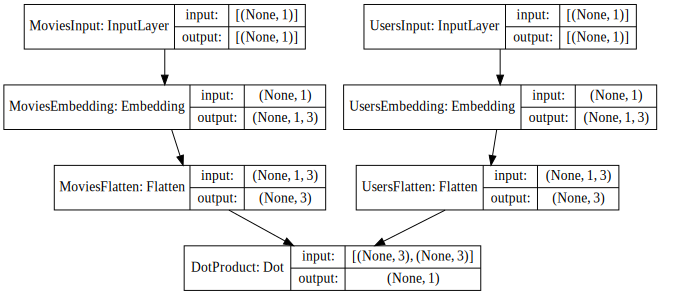

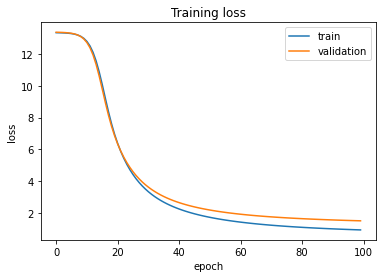

INFO:tensorflow:Assets written to: ./trained_models/base/3_latent_factors\assets


INFO:tensorflow:Assets written to: ./trained_models/base/3_latent_factors\assets


Model: "MatrixFactorizationReccomender"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MoviesInput (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
UsersInput (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
MoviesEmbedding (Embedding)     (None, 1, 3)         29172       MoviesInput[0][0]                
__________________________________________________________________________________________________
UsersEmbedding (Embedding)      (None, 1, 3)         1830        UsersInput[0][0]                 
_____________________________________________________________________

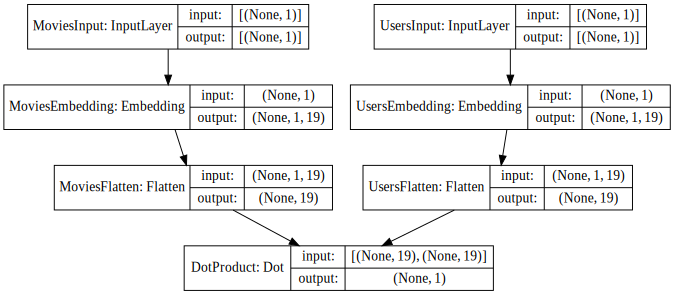

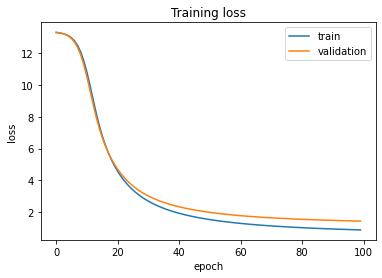

INFO:tensorflow:Assets written to: ./trained_models/base/19_latent_factors\assets


INFO:tensorflow:Assets written to: ./trained_models/base/19_latent_factors\assets


Model: "MatrixFactorizationReccomender"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MoviesInput (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
UsersInput (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
MoviesEmbedding (Embedding)     (None, 1, 19)        184756      MoviesInput[0][0]                
__________________________________________________________________________________________________
UsersEmbedding (Embedding)      (None, 1, 19)        11590       UsersInput[0][0]                 
_____________________________________________________________________

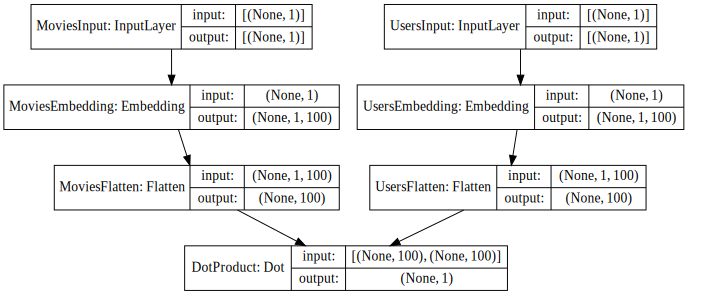

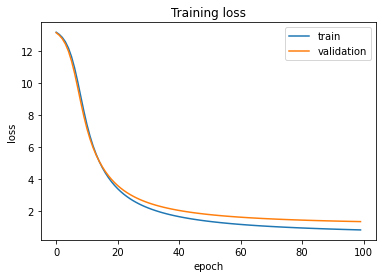

INFO:tensorflow:Assets written to: ./trained_models/base/100_latent_factors\assets


INFO:tensorflow:Assets written to: ./trained_models/base/100_latent_factors\assets


Model: "MatrixFactorizationReccomender"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MoviesInput (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
UsersInput (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
MoviesEmbedding (Embedding)     (None, 1, 100)       972400      MoviesInput[0][0]                
__________________________________________________________________________________________________
UsersEmbedding (Embedding)      (None, 1, 100)       61000       UsersInput[0][0]                 
_____________________________________________________________________

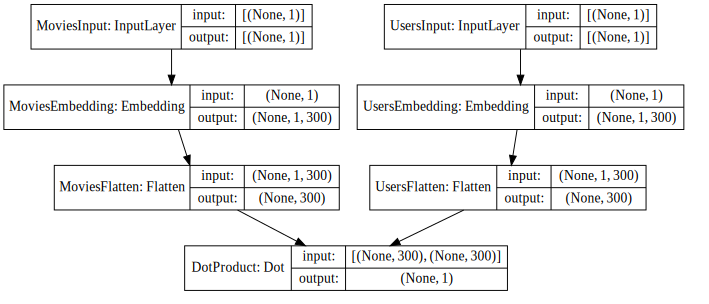

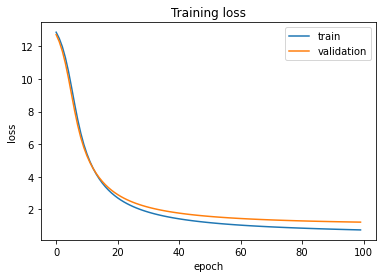

INFO:tensorflow:Assets written to: ./trained_models/base/300_latent_factors\assets


INFO:tensorflow:Assets written to: ./trained_models/base/300_latent_factors\assets


Model: "MatrixFactorizationReccomender"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MoviesInput (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
UsersInput (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
MoviesEmbedding (Embedding)     (None, 1, 300)       2917200     MoviesInput[0][0]                
__________________________________________________________________________________________________
UsersEmbedding (Embedding)      (None, 1, 300)       183000      UsersInput[0][0]                 
_____________________________________________________________________

In [15]:
model_array = []
for lf in LATENT_FACTORS:
    model = BaseCFModel(N_USERS, N_MOVIES, lf)
    model.compile()
    model.train(train_data, epochs = 100, batch = 32)
    model.save(f'./trained_models/base/{lf}_latent_factors')
    model.load_model(f'./trained_models/base/{lf}_latent_factors')
    movie_embeddings = model.get_movies_embeddings()
    movie_embeddings_frame = pd.DataFrame(movie_embeddings)
    movie_embeddings_frame['movieId'] = list(dict_movies.values())
    movie_embeddings_frame.to_csv(f'../results/movie_embeddings/movie_embeddings_{lf}_latent_factors.csv')
    
    user_embedding_learnt = model.model.get_layer(name='UsersEmbedding').get_weights()[0][USER_ID]
    memb = movie_embeddings[movies_not_watched]
    memb = memb.reshape(memb.shape[0], lf)
    movies = user_embedding_learnt @ memb.T
    recommendations = np.argpartition(movies, -MOVIES_TO_RECOMMEND)[-MOVIES_TO_RECOMMEND:]
    print(f'Reccomendations with {lf} latent factors:\n{recommendations}')
    recommended_movies_ids = []
    for val in recommendations:
        recommended_movies_ids.append(reverse_dict_movies[val])
    print(f'Recommended {MOVIES_TO_RECOMMEND} movies with {lf} latent factors: \n')
    print(movies_data[movies_data.movieId.isin(recommended_movies_ids)])
    print(f'Evaluation mse: {np.sqrt(mean_squared_error(ratings_matrix.rating, model.predict(ratings_matrix)))}')